In [1]:
import sys
import joblib
import os
import scipy.io as sio
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [3]:
project = 'fvcom'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = False
latent_dim = 50

In [5]:
u1 = np.load(f'{project_root}/data/{project}/u_interp.npy') 
u2 = np.load(f'{project_root}/data/{project}/v_interp.npy')
nt, n1, n2 = u1.shape
mask = ~np.isnan(u1[0,:,:])

X, scaler = transform_data_for_AE(u1,u2)

mask_tensor = torch.tensor(mask).bool()

def mask_loss(recon_x, x):
    batch_size = x.size(0)
    mask_expanded = mask_tensor.unsqueeze(0).unsqueeze(0).expand(batch_size, x.size(1), n1, n2)
    return nn.MSELoss()(recon_x[mask_expanded], x[mask_expanded])

print(f"Data shape: {X.shape}, Mask shape: {mask.shape}")

Data shape: (15475, 2, 64, 64), Mask shape: (64, 64)


In [6]:
# === Consistent train/val/test split ===
n_train = int(0.3 * nt)
n_val = int(0.2 * nt)
n_test = nt - n_train - n_val

train_idx = np.arange(0, n_train)
val_idx = np.arange(n_train, n_train + n_val)
test_idx = np.arange(n_train + n_val, nt)

X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

train_dataset = TensorDataset(torch.tensor(X_train).float())
val_dataset = TensorDataset(torch.tensor(X_val).float())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

Train shape: (4642, 2, 64, 64), Val shape: (3095, 2, 64, 64), Test shape: (7738, 2, 64, 64)


In [7]:
# === PCA Model ===
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/pca_model.pkl'):
    pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_model.pkl')
else:
    pca = PCA_AE(latent_dim=latent_dim, mask=mask)
    pca.train(X_train)
    pca.save(f'{project_root}/src/models/checkpoints/{project}/pca_model.pkl')

Epoch 1/1000 - Train Loss: 0.4491 - Val Loss: 0.2808
Epoch 2/1000 - Train Loss: 0.2493 - Val Loss: 0.2161
Epoch 3/1000 - Train Loss: 0.2061 - Val Loss: 0.1873
Epoch 4/1000 - Train Loss: 0.1801 - Val Loss: 0.1659
Epoch 5/1000 - Train Loss: 0.1648 - Val Loss: 0.1542
Epoch 6/1000 - Train Loss: 0.1533 - Val Loss: 0.1461
Epoch 7/1000 - Train Loss: 0.1454 - Val Loss: 0.1401
Epoch 8/1000 - Train Loss: 0.1387 - Val Loss: 0.1338
Epoch 9/1000 - Train Loss: 0.1331 - Val Loss: 0.1284
Epoch 10/1000 - Train Loss: 0.1289 - Val Loss: 0.1237
Epoch 11/1000 - Train Loss: 0.1251 - Val Loss: 0.1199
Epoch 12/1000 - Train Loss: 0.1219 - Val Loss: 0.1192
Epoch 13/1000 - Train Loss: 0.1189 - Val Loss: 0.1113
Epoch 14/1000 - Train Loss: 0.1165 - Val Loss: 0.1086
Epoch 15/1000 - Train Loss: 0.1148 - Val Loss: 0.1108
Epoch 16/1000 - Train Loss: 0.1126 - Val Loss: 0.1040
Epoch 17/1000 - Train Loss: 0.1104 - Val Loss: 0.1035
Epoch 18/1000 - Train Loss: 0.1087 - Val Loss: 0.1012
Epoch 19/1000 - Train Loss: 0.1072 - 

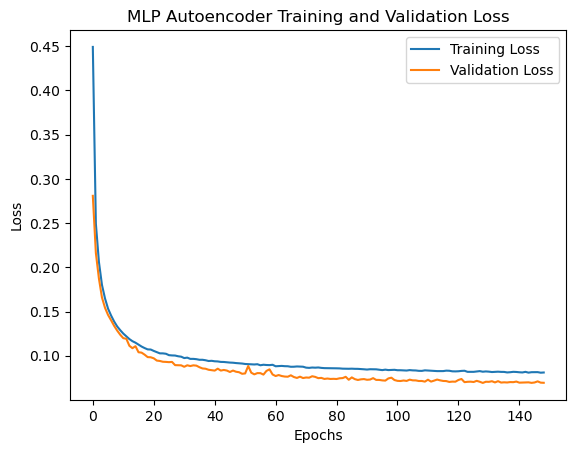

In [12]:
# === MLP Autoencoder ===
# Prepare datasets and loaders
mlp_input_dim = X[:, :, mask].reshape(X.shape[0], -1).shape[1]

mlp = MLP_AE(input_dim=mlp_input_dim, latent_dim=latent_dim, mask=mask)
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/mlp_model.pth'):
    mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_model.pth'))
    training_loss_mlp = np.load(f'{project_root}/src/models/checkpoints/{project}/mlp_training_loss.npy')
    validation_losses_mlp = np.load(f'{project_root}/src/models/checkpoints/{project}/mlp_validation_losses.npy')
else:
    training_loss_mlp, validation_losses_mlp = mlp.train_model(
                                                    train_loader=train_loader,
                                                    val_loader=val_loader,
                                                    device=device,
                                                    loss_fn=mask_loss,
                                                    patience=20,
                                                    save_path=f'{project_root}/src/models/checkpoints/{project}/mlp_model.pth'
                                                )
    np.save(f'{project_root}/src/models/checkpoints/{project}/mlp_training_loss.npy', training_loss_mlp)
    np.save(f'{project_root}/src/models/checkpoints/{project}/mlp_validation_losses.npy', validation_losses_mlp)

plt.plot(training_loss_mlp, label='Training Loss')
plt.plot(validation_losses_mlp, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP Autoencoder Training and Validation Loss')
plt.legend()

Epoch [1/1000], Training Loss: 0.4818, Validation Loss: 0.2990
Epoch [2/1000], Training Loss: 0.2507, Validation Loss: 0.2301
Epoch [3/1000], Training Loss: 0.2113, Validation Loss: 0.2048
Epoch [4/1000], Training Loss: 0.1863, Validation Loss: 0.1873
Epoch [5/1000], Training Loss: 0.1709, Validation Loss: 0.1784
Epoch [6/1000], Training Loss: 0.1602, Validation Loss: 0.1649
Epoch [7/1000], Training Loss: 0.1502, Validation Loss: 0.1605
Epoch [8/1000], Training Loss: 0.1452, Validation Loss: 0.1727
Epoch [9/1000], Training Loss: 0.1398, Validation Loss: 0.1513
Epoch [10/1000], Training Loss: 0.1343, Validation Loss: 0.1489
Epoch [11/1000], Training Loss: 0.1301, Validation Loss: 0.1417
Epoch [12/1000], Training Loss: 0.1259, Validation Loss: 0.1480
Epoch [13/1000], Training Loss: 0.1222, Validation Loss: 0.1339
Epoch [14/1000], Training Loss: 0.1200, Validation Loss: 0.1337
Epoch [15/1000], Training Loss: 0.1162, Validation Loss: 0.1364
Epoch [16/1000], Training Loss: 0.1143, Validatio

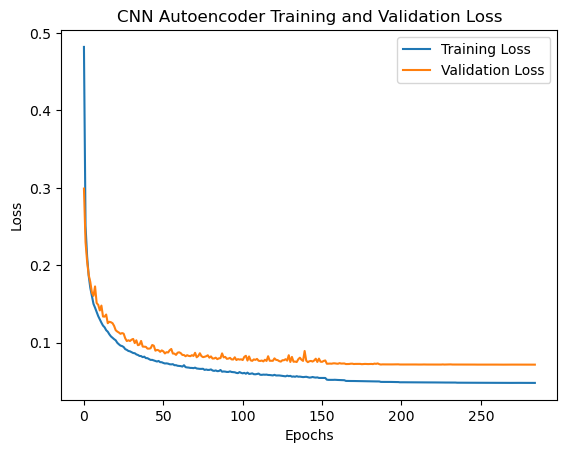

In [13]:
# === CNN Autoencoder with mask-aware loss === #

# Create DataLoader from TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train).float())
val_dataset = TensorDataset(torch.tensor(X_val).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

# Instantiate CNN and train with the mask-aware loss
cnn = CNN_AE(latent_dim=latent_dim)
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/cnn_model.pth'):
    cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_model.pth'))
    training_losses_cnn = np.load(f'{project_root}/src/models/checkpoints/{project}/cnn_training_loss.npy')
    validation_losses_cnn = np.load(f'{project_root}/src/models/checkpoints/{project}/cnn_validation_losses.npy')
else:
    training_losses_cnn, validation_losses_cnn = cnn.train_model(
                                                    train_loader,
                                                    val_loader=val_loader,
                                                    device=device,
                                                    loss_fn=mask_loss,
                                                    patience=20,
                                                    save_path=f'{project_root}/src/models/checkpoints/{project}/cnn_model.pth')
    np.save(f'{project_root}/src/models/checkpoints/{project}/cnn_training_loss.npy', training_losses_cnn)
    np.save(f'{project_root}/src/models/checkpoints/{project}/cnn_validation_losses.npy', validation_losses_cnn)

plt.plot(training_losses_cnn, label='Training Loss')
plt.plot(validation_losses_cnn, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Autoencoder Training and Validation Loss')
plt.legend()